# Wordcloud Generator for Google Search Results

This notebook downloads the top N Google search results for a given query, extracts and cleans the text content, and generates a word cloud based on word frequency.

Developed for Toine Pieters by deSagaz. Assisted by Proton's Lumo AI.

## Set up Environment

In [1]:
# PERFORM IMPORTS

from dotenv import load_dotenv
import os
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from googleapiclient.discovery import build
import time
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from playwright.async_api import async_playwright
from bs4 import BeautifulSoup
from readability import Document          # extracts the “main” article
import re
from collections import Counter
import numpy as np
from PIL import Image, ImageDraw

# --------------------------------------------------------------
# Ensure the required NLTK data files are present (run once)
# --------------------------------------------------------------
nltk.download('stopwords', quiet=True)
nltk.download('wordnet',   quiet=True)

True

In [2]:
# LOAD ENV VARIABLES

load_dotenv()

True

In [3]:
# SET VARIABLES

# Query parameters
query   = "Thalidomide" # Search query
wanted  = 50      # number of URLs total
lang = "en"  # language restriction

# Processing parameters
min_hits = 20 # Remove any words with less than x occurrences


# GOOGLE CSE PARAMETERS
# Set with a .env file containing: API_KEY=your_key CSE_ID=your_cse_id
API_KEY = os.getenv("API_KEY")
CSE_ID  = os.getenv("CSE_ID")

## Retrieve URLs from Google CSE

In [4]:
# DEFINE SEARCH HELPER FUNCTION

# Enables downloading more than 10 results from Google CSE
# Only retrieves HTML pages, ignores PDF files
def google_cse_all(
        query: str,
        api_key: str,
        cse_id: str,
        total: int = 30,
        lang: str = "en",
        safe: str = "off",
        pause: float = 1.0,
) -> list:
    """
    Retrieve up to `total` result URLs from Google Custom Search.

    Parameters
    ----------
    query : str
        Search term.
    api_key : str
        Your Google Cloud API key.
    cse_id : str
        ID of the Custom Search Engine you created.
    total : int, default 30
        Desired number of URLs (must be >= 1).
    lang : str, default "en"
        Language restriction (e.g., "en", "fr").
    safe : str, default "off"
        Safe‑search level: "off", "medium", or "high".
    pause : float, default 1.0
        Seconds to wait between successive API calls (helps stay within quota).

    Returns
    -------
    list[str]
        List of result URLs (may be shorter than `total` if the engine runs out of matches).
    """
    service = build("customsearch", "v1", developerKey=api_key)

    collected = []                 # final list of URLs
    start_index = 1                # API uses 1‑based indexing
    max_per_call = 10              # API limit per request

    while len(collected) < total:
        # How many results do we need in this round?
        remaining = total - len(collected)
        num = min(max_per_call, remaining)

        try:
            resp = (
                service.cse()
                .list(
                    q=query + ' -filetype:pdf',
                    cx=cse_id,
                    lr=f"lang_{lang}",
                    safe=safe,
                    start=start_index,
                    num=num,
                )
                .execute()
            )
        except Exception as exc:
            print(f"❗️ API request failed (start={start_index}): {exc}")
            break

        items = resp.get("items", [])
        if not items:
            # No more results available for this query.
            print("ℹ️ No further items returned – reached end of result set.")
            break

        # Append the URLs from this batch.
        batch_urls = [item["link"] for item in items]
        collected.extend(batch_urls)

        # Prepare for the next page.
        start_index += len(items)

        # Respect a short pause to avoid hitting per‑second quotas.
        time.sleep(pause)

    # Trim in case the last batch overshot the target.
    return collected[:total]

In [5]:
# EXECUTE GOOGLE SEARCH, RETRIEVE URLS

urls = google_cse_all(
    query=query,
    api_key=API_KEY,
    cse_id=CSE_ID,
    total=wanted,
    lang=lang,
    safe="off",
    pause=1.2,           # a little slower than the default
)

In [6]:
# PRINT RETRIEVED URLS

print(f"\n✅ Retrieved {len(urls)} URLs (requested {wanted}):")
for i, u in enumerate(urls, 1):
    print(f"{i:02d}. {u}")


✅ Retrieved 50 URLs (requested 50):
01. https://en.wikipedia.org/wiki/Thalidomide
02. https://www.sciencemuseum.org.uk/objects-and-stories/medicine/thalidomide
03. https://en.wikipedia.org/wiki/Thalidomide_scandal
04. https://medlineplus.gov/druginfo/meds/a699032.html
05. https://pubmed.ncbi.nlm.nih.gov/21507989/
06. https://thalidomidetrust.org/about-us/about-thalidomide/
07. https://www.mayoclinic.org/drugs-supplements/thalidomide-oral-route/description/drg-20066301
08. https://pmc.ncbi.nlm.nih.gov/articles/PMC3573415/
09. https://www.ncbi.nlm.nih.gov/books/NBK583704/
10. https://pmc.ncbi.nlm.nih.gov/articles/PMC4737249/
11. https://www.dana-farber.org/newsroom/news-releases/2018/after-60-years-scientists-uncover-how-thalidomide-produced-birth-defects
12. https://ashpublications.org/blood/article/111/8/3968/24563/Thalidomide-for-treatment-of-multiple-myeloma-10
13. https://www.myeloma.org/thalomid-thalidomide
14. https://www.fda.gov/drugs/postmarket-drug-safety-information-patients-

## Download and Process Web Pages

In [7]:
# DEFINE FUNCTION TO FETCH HTML FROM SINGLE URL USING PLAYWRIGHT
# Playwright is necessary to avoid bot detection on some sites

async def fetch_html(url, user_agent):
    async with async_playwright() as p:
        browser = await p.chromium.launch(headless=True)
        context = await browser.new_context(user_agent=user_agent)
        page = await context.new_page()
        await page.goto(url)
        await page.wait_for_timeout(1000)
        html = await page.content()
        await browser.close()
        return html


In [8]:
# DEFINE FUNCTION TO FETCH AND PROCESS MULTIPLE URLS

async def process_urls(urls):
    web_content_all_raw = []
    my_range = range(len(urls))          # adjust as needed
    wanted = len(urls)                # ensure `urls` is defined

    for u in my_range:
        print(f"Processing URL {u+1}/{wanted}: {urls[u]}")
        try:
            raw_content = await fetch_html(
                urls[u],
                user_agent=(
                    "Mozilla/5.0 (Windows NT 10.0; Win64; x64) "
                    "AppleWebKit/537.36 (KHTML, like Gecko) "
                    "Chrome/69.0.3497.100 Safari/537.36"
                )
            )
            web_content_all_raw.append(raw_content)
        except Exception as e:
            print(f"Failed to retrieve or process URL {urls[u]} – {e}")

    return web_content_all_raw

In [9]:
# FETCH HTML FOR ALL RETRIEVED URLS

web_content_all_raw = await process_urls(urls)
print(f"Fetched {len(web_content_all_raw)} pages.")

Processing URL 1/50: https://en.wikipedia.org/wiki/Thalidomide
Processing URL 2/50: https://www.sciencemuseum.org.uk/objects-and-stories/medicine/thalidomide
Processing URL 3/50: https://en.wikipedia.org/wiki/Thalidomide_scandal
Processing URL 4/50: https://medlineplus.gov/druginfo/meds/a699032.html
Processing URL 5/50: https://pubmed.ncbi.nlm.nih.gov/21507989/
Processing URL 6/50: https://thalidomidetrust.org/about-us/about-thalidomide/
Processing URL 7/50: https://www.mayoclinic.org/drugs-supplements/thalidomide-oral-route/description/drg-20066301
Processing URL 8/50: https://pmc.ncbi.nlm.nih.gov/articles/PMC3573415/
Processing URL 9/50: https://www.ncbi.nlm.nih.gov/books/NBK583704/
Processing URL 10/50: https://pmc.ncbi.nlm.nih.gov/articles/PMC4737249/
Processing URL 11/50: https://www.dana-farber.org/newsroom/news-releases/2018/after-60-years-scientists-uncover-how-thalidomide-produced-birth-defects
Processing URL 12/50: https://ashpublications.org/blood/article/111/8/3968/24563/Th

In [10]:
# CLEAN AND TOKENISE THE HTML CONTENT

def words_from_html(html: str) -> list[str]:
    """
    Extracts the visible text from the *main* article of an HTML page
    and returns a flat list of lower‑cased word tokens.
    """
    # ①  Use readability‑lxml to isolate the primary content block.
    #     It strips navigation, ads, footers, etc.
    doc = Document(html)
    main_html = doc.summary()               # HTML that represents the article
    
    # Preview results
    # print(f"Extracted main content (first 500 chars):\n{main_html[:500]}\n...\n")

    # ②  Parse that snippet with BeautifulSoup so we can strip any remaining tags.
    soup = BeautifulSoup(main_html, "lxml")
    text = soup.get_text(separator=" ")    # plain text, spaces keep words separate
    
    # Preview results
    # print(f"Extracted text (first 500 chars):\n{text[:500]}\n...\n")

    # ③  Normalise whitespace and remove non‑alphabetic characters.
    #     This regex keeps letters, numbers and apostrophes (e.g. “don’t”).
    cleaned = re.sub(r"[^\w\'\-]+", " ", text)

    # Preview results
    # print(f"Cleaned text (first 500 chars):\n{cleaned[:500]}\n...\n")

    # ④  Tokenise into words. NLTK’s word_tokenize handles punctuation nicely.
    tokens = nltk.word_tokenize(cleaned)
    
    # Preview results
    # print(f"Tokenised words (first 100 tokens):\n{tokens[:100]}\n...\n")

    # ⑤  Lower‑case and drop stray punctuation tokens.
    words = [t.lower() for t in tokens if re.search(r"\w", t)]
    
    # Preview results
    # print(f"Final word list (first 100 words):\n{words[:100]}\n...\n")

    return words

In [11]:
## EXTRACT WORDS FROM PAGES

all_words_per_page = [words_from_html(page) for page in web_content_all_raw]
all_words_flat = [word for sublist in all_words_per_page for word in sublist]

print(f"First 200 words from page 0: {all_words_per_page[0][:200]}")
print(f"Total words across all pages: {len(all_words_flat)}")
print(f"Total unique words across all pages: {len(set(all_words_flat))}")

First 200 words from page 0: ['immunomodulatory', 'drug', 'which', 'can', 'cause', 'birth', 'defects', 'this', 'article', 'is', 'about', 'the', 'drug', 'for', 'the', 'thalidomide', 'scandal', 'and', 'birth', 'defect', 'crisis', 'see', 'thalidomide', 'scandal', 'pharmaceutical', 'compound', 'thalidomide', 'pronunciation', '1', 'trade', 'names', 'contergan', 'thalomid', 'others', 'other', 'names', 'α-phthalimidoglutarimide', 'ahfs', 'drugs', 'com', 'monograph', 'medlineplus', 'a699032', 'license', 'data', 'pregnancy', 'category', 'routes', 'of', 'administration', 'by', 'mouth', 'atc', 'code', 'legal', 'status', 'bioavailability', '90', 'protein', 'binding', '55', 'and', '66', 'for', 'the', 'r', 'and', 's', '-enantiomers', 'respectively', '5', 'metabolism', 'liver', 'minimally', 'via', 'cyp2c19', '-mediated', '5-hydroxylation', 'mostly', 'via', 'non-enzymatic', 'hydrolysis', 'at', 'the', 'four', 'amide', 'sites', '5', 'elimination', 'half-life', '5', '7', '5', 'hours', 'dose-dependent', '

In [12]:
# PERFORM WORD NORMALISATION AND STOP‑WORD FILTERING

# ------------------------------------------------------------------
# 1️⃣  Prepare the stop‑word collection
# ------------------------------------------------------------------
base_stop = set(stopwords.words('english'))          # default English stop‑words
publisher_stopwords = {
    'pubmed', 'google', 'scholar', 'crossref', 'doi',
    'pmid', 'pmc', 'pdf', 'www', 'http', 'url',
    'journal', 'article', 'website', 'site',
    'download', 'access', 'file', 'files', 'reference',
    'citation', 'abstract', 'supplement', 'supplementary',
    'author'
}
generic_verbs = {
    'use', 'may', 'also', 'could', 'should', 'must', 'might',
    'can', 'will', 'need', 'have', 'get', 'make', 'take',
    'give', 'see', 'look', 'find', 'call', 'check', 'run',
    'set', 'add', 'remove', 'keep', 'continue', 'stop',
    'help', 'provide', 'offer', 'allow', 'enable', 'disable',
    'write', 'read', 'save', 'load', 'open', 'close',
    'send', 'receive', 'upload', 'download', 'process',
    'perform', 'performing', 'performances', 'performer',
    'performers', 'performers', 'performing', 'perform',
    'perform', 'perform', 'perform', 'perform'  # duplicates are harmless
}

stop_set = base_stop.union(publisher_stopwords).union(generic_verbs)

# ------------------------------------------------------------------
# 2️⃣  Normalise the incoming list of tokens
#    (lower‑case + lemmatise each element)
# ------------------------------------------------------------------
lemmatizer = WordNetLemmatizer()
normalized_tokens = [
    lemmatizer.lemmatize(token.lower()) for token in all_words_flat
]

# ------------------------------------------------------------------
# 3️⃣  Filter out stop‑words
# ------------------------------------------------------------------
filtered_tokens = [tok for tok in normalized_tokens if tok not in stop_set]

# Remove all numbers and short words
filtered_tokens = [tok for tok in filtered_tokens if not tok.isdigit() and len(tok) > 2]

# ------------------------------------------------------------------
# 5️⃣  Show the result
# ------------------------------------------------------------------
print(f"First 200 words: {filtered_tokens[0:200]}")
print(f"Total words: {len(filtered_tokens)}")
print(f"Total unique words: {len(set(filtered_tokens))}")

First 200 words: ['immunomodulatory', 'drug', 'cause', 'birth', 'defect', 'drug', 'thalidomide', 'scandal', 'birth', 'defect', 'crisis', 'thalidomide', 'scandal', 'pharmaceutical', 'compound', 'thalidomide', 'pronunciation', 'trade', 'name', 'contergan', 'thalomid', 'others', 'name', 'α-phthalimidoglutarimide', 'ahfs', 'drug', 'com', 'monograph', 'medlineplus', 'a699032', 'license', 'data', 'pregnancy', 'category', 'route', 'administration', 'mouth', 'atc', 'code', 'legal', 'status', 'bioavailability', 'protein', 'binding', '-enantiomers', 'respectively', 'metabolism', 'liver', 'minimally', 'via', 'cyp2c19', '-mediated', '5-hydroxylation', 'mostly', 'via', 'non-enzymatic', 'hydrolysis', 'four', 'amide', 'elimination', 'half-life', 'hour', 'dose-dependent', 'excretion', 'urine', 'feces', 'semen', 'number', 'pubchem', 'cid', 'iuphar', 'bps', 'drugbank', 'chemspider', 'unii', 'kegg', 'chebi', 'chembl', 'comptox', 'dashboard', 'epa', 'echa', 'infocard', 'formula', 'molar', 'mass', 'mol', '

## Build Popularity Mapping and Generate Word Cloud

In [13]:
# DEFINE FUNCTION TO TURN FLAT WORD LIST INTO POPULARITY MAPPING (word->count)

def build_popularity(word_list):
    """
    Convert a flat list of words into a popularity mapping
    {word: frequency}, sorted from most‑popular to least‑popular.

    Parameters
    ----------
    word_list : iterable of str
        Raw words (may contain mixed case, punctuation, etc.).

    Returns
    -------
    dict
        Mapping word → count, ordered by descending count.
    """
    # ---------- Normalise and clean ----------
    cleaned = []
    for w in word_list:
        # Lower‑case and strip surrounding punctuation
        w = w.lower().strip()
        w = re.sub(r"^[^\w]+|[^\w]+$", "", w)   # drop non‑alphanumeric edges
        if w:                                   # skip empty strings
            cleaned.append(w)

    # ---------- Count frequencies ----------
    freq_counter = Counter(cleaned)   # e.g. Counter({'vpn': 3, 'mail': 2, ...})

    # ---------- Sort by count (descending) ----------
    # `sorted_items` is a list of (word, count) tuples
    sorted_items = sorted(freq_counter.items(),
                          key=lambda item: item[1],
                          reverse=True)

    # Regular dict keeps insertion order in Python ≥3.7
    return dict(sorted_items)

In [14]:
# BUILD THE POPULARITY DICTIONARY

popularity = build_popularity(filtered_tokens)
popularity = {word: count for word, count in popularity.items() if count >= min_hits}

print(popularity)

{'thalidomide': 1848, 'drug': 461, 'patient': 445, 'treatment': 345, 'effect': 312, 'increase': 296, 'cell': 245, 'crbn': 231, 'sedation': 221, 'monitor': 213, 'myeloma': 180, 'study': 168, 'defect': 165, 'limb': 164, 'alternative': 162, 'birth': 149, 'group': 147, 'time': 144, 'therapy': 142, 'multiple': 130, 'blood': 129, 'cause': 125, 'medication': 125, 'protein': 124, 'dose': 123, 'damage': 119, 'mouse': 119, 'serious': 116, 'contraindicated': 114, 'avoid': 110, 'closely': 110, 'human': 107, 'used': 104, 'caution': 102, 'risk': 101, 'day': 100, 'clinical': 99, 'trial': 99, 'new': 96, 'lenalidomide': 96, 'mechanism': 95, 'response': 95, 'including': 94, 'degradation': 92, 'first': 91, 'pregnancy': 90, 'pregnant': 90, 'doctor': 89, 'using': 89, 'alternate': 87, 'action': 85, 'result': 84, 'period': 84, 'medicine': 83, 'activity': 83, 'week': 82, 'development': 81, 'bleeding': 81, 'factor': 81, 'reported': 80, 'however': 80, 'thalomid': 79, 'severe': 79, 'woman': 77, 'retrieved': 76, 

In [15]:
# DEFINE ELLIPSE MASK FUNCTION

def simple_ellipse_mask(width: int,
                        height: int,
                        *,
                        axis_ratio: float = 0.9) -> np.ndarray:
    """
    Produce a binary (uint8) mask containing ONE solid ellipse.

    Parameters
    ----------
    width, height : canvas size in pixels
    axis_ratio    : fraction of the *smaller* canvas side used for the
                    diameter of the ellipse (0 < ratio ≤ 1).
    """
    # Create a black canvas (0 = background)
    mask_img = Image.new("L", (width, height), 255)
    draw = ImageDraw.Draw(mask_img)

    # Compute the ellipse bounding box so it stays centred
    radius = int(min(width, height) * axis_ratio / 2)
    bbox = [
        width // 2 - radius,
        height // 2 - radius,
        width // 2 + radius,
        height // 2 + radius,
    ]

    # Draw a white (255) filled ellipse
    draw.ellipse(bbox, fill=0)

    # Convert to NumPy array – WordCloud expects 0/255 values
    return np.array(mask_img)

In [16]:
# DETERMINE WORD COLOURING FUNCTION BASED ON RANK
# Note: rank is otherwise not used by WordCloud

# --------------------------------------------------------------
# 1️⃣  Build a dict: word → rank (1 = most frequent)
# --------------------------------------------------------------
sorted_words = sorted(popularity.items(),
                      key=lambda kv: kv[1],      # sort by frequency
                      reverse=True)             # highest first

# Assign ranks; ties get the same rank (optional – you can also give
# each occurrence a unique rank if you prefer a strictly linear scale).
rank_lookup = {}
current_rank = 1
prev_freq   = None
for i, (w, f) in enumerate(sorted_words, start=1):
    if f != prev_freq:                # new frequency → bump rank
        current_rank = i
        prev_freq = f
    rank_lookup[w] = current_rank

# Lightest gray you’ll allow (0 = black, 255 = white)
LIGHTEST_GRAY = 220          # words lighter than this become hard to read
# Darkest gray (usually 0 → pure black)
DARKEST_GRAY  = 0

max_rank = len(rank_lookup)

def rank_based_gray_color_func(word, font_size, position, orientation,
                               random_state=None, **kwargs):
    """
    Returns a gray tone whose darkness is determined by the word’s rank.
    Higher rank (more frequent) → darker shade.
    """
    # ----- look up the rank ------------------------------------
    rank = rank_lookup.get(word, len(rank_lookup) + 1)   # fallback: worst rank
    # print (f"Word: {word}, Rank: {rank}")

    # ----- map rank → gray value --------------------------------
    # Number of distinct ranks (max rank)

    if max_rank == 1:                     # edge case – only one word
        gray_val = DARKEST_GRAY
    else:
        norm = (rank-1) / (max_rank-1)
        gray_val = DARKEST_GRAY + (norm ** 0.4) * (LIGHTEST_GRAY-DARKEST_GRAY)

    gray_val = int(round(gray_val))       # ensure an integer 0‑255

    # WordCloud expects a CSS‑style colour string
    return f"rgb({gray_val},{gray_val},{gray_val})"

Generating Word Cloud..


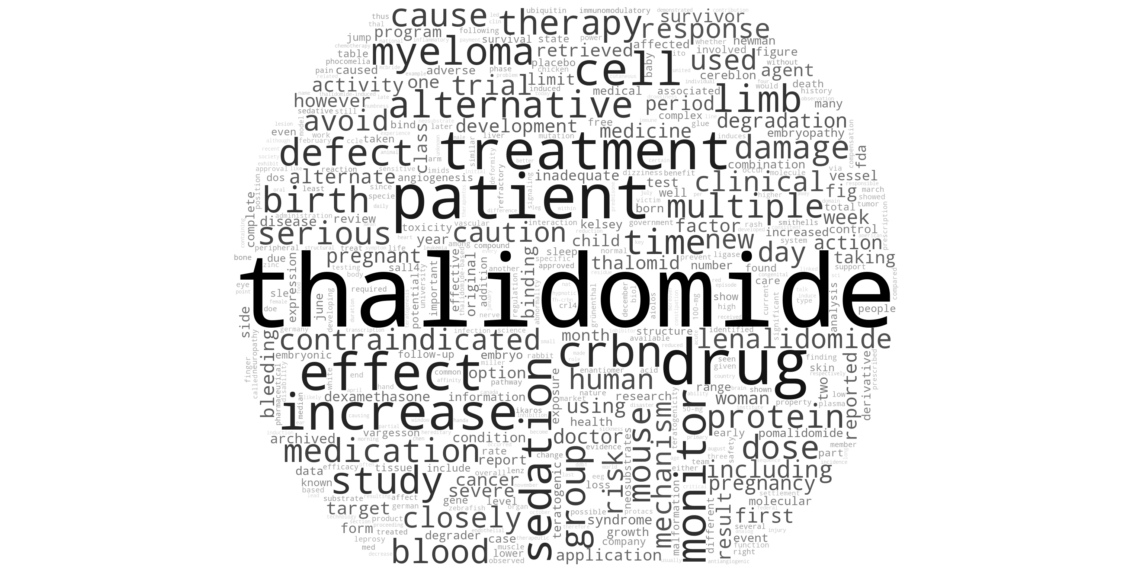

In [18]:
# GENERATE THE WORD CLOUD VISUALISATION

WIDTH = 3000
HEIGHT = 1500

mask = simple_ellipse_mask(WIDTH, HEIGHT, axis_ratio=1.2)  # tweak ratio if you want a tighter/fatter oval

print("Generating Word Cloud..")
wordcloud = WordCloud(max_font_size=300, max_words=500, mask=mask,
                      color_func=rank_based_gray_color_func,
                      prefer_horizontal=.9,
                      background_color="white",random_state=0, height=HEIGHT, width=WIDTH).generate_from_frequencies(popularity)
plt.figure(figsize=(20,40))
plt.imshow(wordcloud, cmap="gray", interpolation="bilinear")
plt.axis("off")
plt.style.use('default')
plt.show()

# Save image
wordcloud.to_file("wordcloud_thalidomide.png")